In [1]:
from __future__ import absolute_import, division, print_function

import argparse
import os
import random
from datetime import datetime

import cv2
import keras
import numpy as np
import pandas as pd
from keras import backend as K
from keras.applications import *
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import *
from keras.utils.vis_utils import model_to_dot
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
# Loading Datasets
print('\n\n Loading Datasets. \n')

df = pd.read_csv('../dog_breed_datasets/labels.csv')
df.head()

n = len(df)
breed = set(df['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

width = 299
X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)
for i in tqdm(range(n)):
    X[i] = cv2.resize(
        cv2.imread('../dog_breed_datasets/train/%s.jpg' % df['id'][i]),
        (width, width))
    y[i][class_to_num[df['breed'][i]]] = 1

dvi = int(X.shape[0]*0.9)
x_train = X[:dvi,:,:,:]
y_train = y[:dvi,:]
x_val = X[dvi:,:,:,:]
y_val = y[dvi:,:]

  0%|          | 32/10222 [00:00<00:32, 313.68it/s]



 Loading Datasets. 



100%|██████████| 10222/10222 [00:25<00:00, 399.15it/s]


In [4]:
# Compute the bottleneck feature

def get_features(MODEL, data=X):
    cnn_model = MODEL(
        include_top=False, input_shape=(width, width, 3), weights='imagenet')

    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=32, verbose=1)
    return features
print('Start computing Xception bottleneck feature: ')
features = get_features(Xception, X)
np.save('features.npy', features, 'w')


Start computing Xception bottleneck feature: 
10222/10222 [==============================] - 157s 15ms/step


In [6]:
# Training models

inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
# x = Dense(n_class, activation='softmax', name='predictions', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dense(n_class, activation='softmax', name='predictions')(x)
model = Model(inputs, x)
model.compile(
    optimizer='Nadam', loss='categorical_crossentropy', metrics=['accuracy'])
h = model.fit(features, y, batch_size=128, epochs=5, validation_split=0.1)

model.save('fc.h5','w')

Train on 9199 samples, validate on 1023 samples
Epoch 1/5
9199/9199 [==============================] - 0s 47us/step - loss: 2.0208 - acc: 0.6208 - val_loss: 0.8266 - val_acc: 0.8084
Epoch 2/5
9199/9199 [==============================] - 0s 19us/step - loss: 0.6746 - acc: 0.8302 - val_loss: 0.6206 - val_acc: 0.8309
Epoch 3/5
9199/9199 [==============================] - 0s 19us/step - loss: 0.5177 - acc: 0.8597 - val_loss: 0.5547 - val_acc: 0.8426
Epoch 4/5
9199/9199 [==============================] - 0s 18us/step - loss: 0.4434 - acc: 0.8735 - val_loss: 0.5355 - val_acc: 0.8456
Epoch 5/5
9199/9199 [==============================] - 0s 19us/step - loss: 0.3875 - acc: 0.8910 - val_loss: 0.5188 - val_acc: 0.8446


Text(0.5,0,u'epoch')

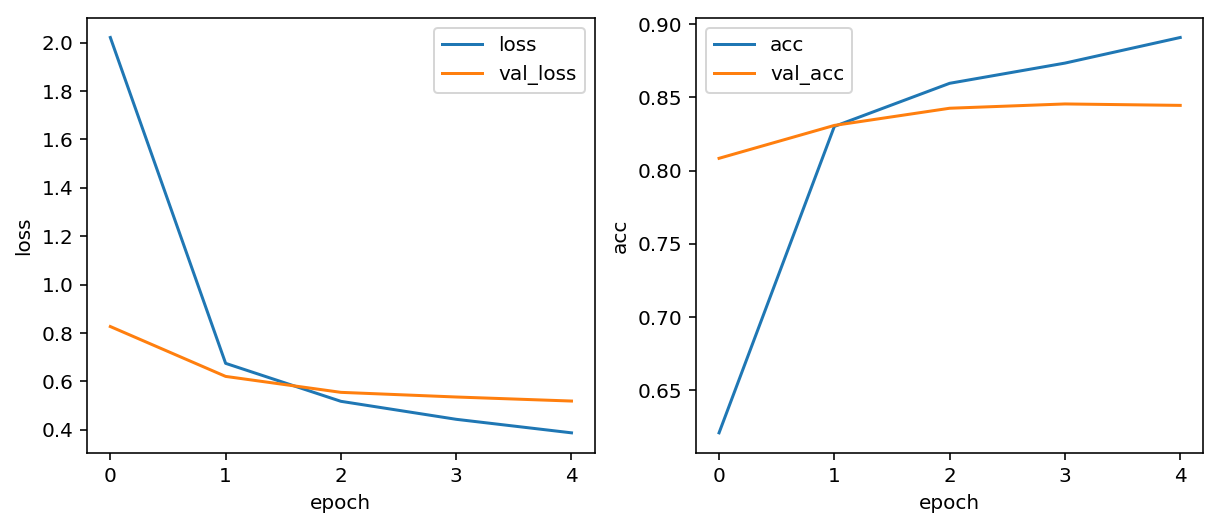

In [7]:
# Training preprocess visualization
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

In [ ]:
# Fine-tune the model
lr=0.0005
optimizer="Nadam" 
epoch=100
patience=2
batch_size=16

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

inputs = Input((width, width, 3))
x = inputs
cnn_model = Xception(include_top=False, input_shape=(width, width, 3), weights='imagenet')
x = cnn_model(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax', name='predictions')(x)
model = Model(inputs=inputs, outputs=x)

# for layer in model.layers[:114]:
#     layer.trainable = False

try:
    model.load_weights('Xception.h5')
    print('Load Xception.h5 successfully.')
except:
    model.load_weights('fc.h5', by_name=True)
    print('Fail to load Xception1.h5, load fc.h5 instead.')
          
# model.compile(optimizer=Nadam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.0005, momentum=0.9, nesterov=True, decay=0.0023),
              metrics=['accuracy'])

batch_size = 16
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.val_losses = []
        self.losses = []
    def on_epoch_end(self, batch, logs={}):
        self.val_losses.append(logs.get("val_loss"))
        self.losses.append(logs.get('loss'))

history = LossHistory()

early_stopping = EarlyStopping(
    monitor='val_loss', patience=patience, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(
    filepath='Xception.h5', verbose=1, save_best_only=True)
h2 = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) / batch_size,
    validation_data=val_datagen.flow(
        x_val, y_val, batch_size=batch_size),
    validation_steps=len(x_val) / batch_size,
    epochs=epoch,
    callbacks=[early_stopping, checkpointer, history])
#         print(history.losses)
np.savetxt("val_losses_"+str(optimizer)+"_"+str(lr)+".csv", history.losses)
np.savetxt("losses_"+str(optimizer)+"_"+str(lr)+".csv", history.val_losses)

model.save('Xception.h5','w')

Load Xception.h5 successfully.
Epoch 1/100
575/574 [==============================] - 506s 881ms/step - loss: 0.1693 - acc: 0.9504 - val_loss: 0.4460 - val_acc: 0.8710
Epoch 2/100
575/574 [==============================] - 502s 874ms/step - loss: 0.1499 - acc: 0.9537 - val_loss: 0.4426 - val_acc: 0.8700
Epoch 3/100
575/574 [==============================] - 502s 873ms/step - loss: 0.1380 - acc: 0.9599 - val_loss: 0.4358 - val_acc: 0.8739
Epoch 4/100
575/574 [==============================] - 504s 877ms/step - loss: 0.1329 - acc: 0.9625 - val_loss: 0.4289 - val_acc: 0.8759
Epoch 5/100
575/574 [==============================] - 503s 874ms/step - loss: 0.1280 - acc: 0.9639 - val_loss: 0.4314 - val_acc: 0.8749
Epoch 6/100
339/574 [================>.............] - ETA: 3:20 - loss: 0.1201 - acc: 0.9670

In [14]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h2.history['loss'])
plt.plot(h2.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h2.history['acc'])
plt.plot(h2.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

NameError: name 'h2' is not defined

In [8]:
history.val_losses

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,